<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import sys

if "google.colab" in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/dataset'

    # Install required packages
    !pip install torch_geometric
    import torch
    from torch_geometric.data import Data, DataLoader

else:
    dataset_path = 'dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The data

In [25]:
# Load the data
# Training set
train_graphs = torch.load(f"{dataset_path}/combined/training.pt", weights_only=False)

# Validating set
val_graphs = torch.load(f"{dataset_path}/combined/validating.pt", weights_only=False)

# Testing set
test_graphs = torch.load(f"{dataset_path}/combined/testing.pt", weights_only=False)

In [26]:
# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

## Build model

### import dependancies

In [27]:
# import dependancies
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv

In [28]:
# Model focused on structure only
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr,):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.fc2(x)
        return x

In [29]:
'''
# Model considering global attributes
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, global_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn, aggr='mean')

        self.fc1 = nn.Linear(hidden_dim + global_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr, batch, global_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = torch.cat([x, global_attr], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
'''

"\n# Model considering global attributes\nclass GNNModel(nn.Module):\n    def __init__(self, node_dim, edge_dim, global_dim, hidden_dim):\n        super().__init__()\n        # Edge NN maps edge_attr to weight matrix\n        self.edge_nn = nn.Sequential(\n            nn.Linear(edge_dim, 32),\n            nn.ReLU(),\n            nn.Linear(32, node_dim * hidden_dim)\n        )\n\n        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')\n        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn, aggr='mean')\n\n        self.fc1 = nn.Linear(hidden_dim + global_dim, hidden_dim)\n        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output\n\n    def forward(self, x, edge_index, edge_attr, batch, global_attr):\n        x = F.relu(self.conv1(x, edge_index, edge_attr))\n        x = F.relu(self.conv2(x, edge_index, edge_attr))\n        x = global_mean_pool(x, batch)\n        x = torch.cat([x, global_attr], dim=1)\n        x = F.relu(self.fc1(x))\n        return s

### model instance, optimizer, loss function

In [30]:
# Instantiate model, optimizer, loss

# run the model in the gpu if the device has one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instance of the model
model = GNNModel(node_dim=8, edge_dim=3, hidden_dim=32).to(device) # Without global features
# model = GNNModel(node_dim=8, edge_dim=3, global_dim=10, hidden_dim=32).to(device) # with global features


# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
loss_fn = nn.MSELoss()

### Train and validation loops

In [31]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        # out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.u) # With global attributes
        out = model(data.x, data.edge_index, data.edge_attr) # Without global attributes
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

In [32]:
def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.u) # With global attributes
            out = model(data.x, data.edge_index, data.edge_attr) # Without global attributes
            loss = loss_fn(out, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [33]:
### Training, validating, and testing

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 001, Train Loss: 239.2805, Val Loss: 69.7998


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([313, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 002, Train Loss: 20.8789, Val Loss: 8.7876


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([287, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([338, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 003, Train Loss: 4.4319, Val Loss: 1.8645
Epoch 004, Train Loss: 1.9199, Val Loss: 0.6223


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([302, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 005, Train Loss: 1.0072, Val Loss: 0.6671
Epoch 006, Train Loss: 0.6830, Val Loss: 0.5967
Epoch 007, Train Loss: 0.5113, Val Loss: 0.4645


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([266, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 008, Train Loss: 0.4261, Val Loss: 0.4273


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([420, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 009, Train Loss: 0.4069, Val Loss: 0.4058
Epoch 010, Train Loss: 0.3913, Val Loss: 0.3887


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([274, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 011, Train Loss: 0.3781, Val Loss: 0.3846


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([251, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 012, Train Loss: 0.3662, Val Loss: 0.3457


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([307, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 013, Train Loss: 0.3412, Val Loss: 0.3326
Epoch 014, Train Loss: 0.3307, Val Loss: 0.3209


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([403, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([332, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 015, Train Loss: 0.3165, Val Loss: 0.3088
Epoch 016, Train Loss: 0.3054, Val Loss: 0.2978
Epoch 017, Train Loss: 0.3141, Val Loss: 0.2886
Epoch 018, Train Loss: 0.2918, Val Loss: 0.2782


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([273, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([279, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([350, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 019, Train Loss: 0.2856, Val Loss: 0.2739


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([258, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 020, Train Loss: 0.2793, Val Loss: 0.2640


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([254, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([308, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 021, Train Loss: 0.2734, Val Loss: 0.2572


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([318, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 022, Train Loss: 0.2637, Val Loss: 0.2500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([276, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 023, Train Loss: 0.2590, Val Loss: 0.2447
Epoch 024, Train Loss: 0.2513, Val Loss: 0.2400


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([253, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([259, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 025, Train Loss: 0.2504, Val Loss: 0.2374
Epoch 026, Train Loss: 0.2573, Val Loss: 0.2282


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([314, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 027, Train Loss: 0.2401, Val Loss: 0.2256


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([284, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([407, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([252, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 028, Train Loss: 0.2387, Val Loss: 0.2180
Epoch 029, Train Loss: 0.2323, Val Loss: 0.2259
Epoch 030, Train Loss: 0.2235, Val Loss: 0.2137


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([383, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 031, Train Loss: 0.2249, Val Loss: 0.2088
Epoch 032, Train Loss: 0.2229, Val Loss: 0.2033
Epoch 033, Train Loss: 0.2233, Val Loss: 0.2163


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([414, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 034, Train Loss: 0.2379, Val Loss: 0.2961


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 035, Train Loss: 0.2209, Val Loss: 0.2130
Epoch 036, Train Loss: 0.2271, Val Loss: 0.2377


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 037, Train Loss: 0.2291, Val Loss: 0.2332
Epoch 038, Train Loss: 0.2209, Val Loss: 0.2425
Epoch 039, Train Loss: 0.2087, Val Loss: 0.1866


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([268, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([391, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 040, Train Loss: 0.1947, Val Loss: 0.1951
Test Loss: 0.1969


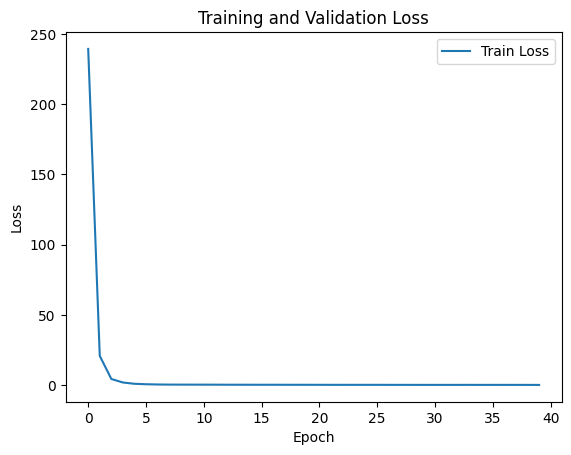

In [34]:
# Run training and testing
import matplotlib.pyplot as plt
train_losses = []
val_losses = []
for epoch in range(1, 41):
    train_loss = train()
    val_loss = evaluate(val_loader)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Plotting the training and validation loss
plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
